### Fixed Horizon Methods

금융에 있어서 거의 모든 머신러닝 논문은 고정 기간(fixed horizon) 기법으로 관측값을 labeling한다. 이 기법은 다음과 같이 설명할 수 있다. 인덱스가 $t=1, \dots, T$인 어떤 bar로부터 추출된 $I(I \leq T)$개 행을 가진 특성 행렬 $X, \{X_i\}_{i, \dots, I}$를 생각해 보자. Chapter2의 마지막 부분에서 특성 집합 $\{x_i\}_{i,\dots,I}$를 생성하는 표본 추출 기법을 알아보았다. 관측값 $X_i$에는 label $y_i \in \{-1, 0, 1\}$이 할당된다.

$$
y_i=
\begin{cases}
-1 & \mbox{ if } r_{t_{i,0}, t_{i,0}+h} < -\tau\\
0 & \mbox{if } |r_{t_{i,0}, t_{i,0}+h}| \leq \tau\\
1 & \mbox{if } r_{t_{i,0}, t_{i,0}+h} > \tau
\end{cases}
$$

여기서 $\tau$는 사전에 정의된 상수 임계값이고, $t_{i,0}$은 $X_i$가 발생한 직후의 bar index를 의미하며, $t_{i,0} + h$는 $t_{i,0}$이후 $h$번째의 bar index, $r_{t_{i,0}, t_{i,0}+h}$는 바 기간 $h$에 대한 가격 수익률이다

$$r_{t_{i,0}, t_{i,0}+h} = \frac{p_{t_{i,0}+h}}{p_{t_{i,0}}} - 1$$

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

start_date = '2000-01-01'
end_date = '2024-04-06'
ticker = '^GSPC'
data = yf.download(
    ticker, 
    start = start_date, 
    end = end_date
)

[*********************100%%**********************]  1 of 1 completed


In [2]:
ret = data['Close'].pct_change(fill_method = None).dropna()

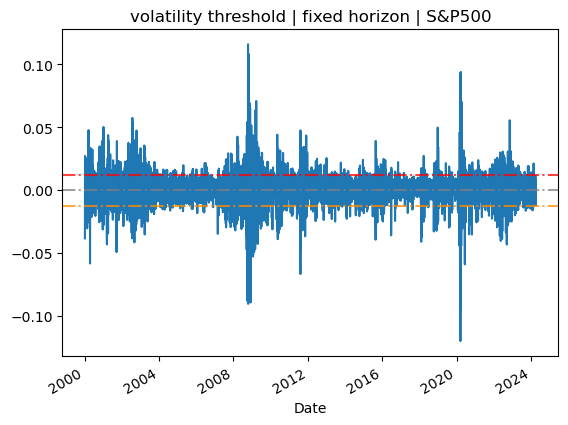

In [19]:
ret.plot(grid = False)
plt.axhline(y = ret.std(), color = 'red', linestyle = '-.', alpha = 0.75)
plt.axhline(y = 0, color = 'gray', linestyle = '-.', alpha = 0.75)
plt.axhline(y = -ret.std(), color = 'darkorange', linestyle = '-.', alpha = 0.75)
plt.title('volatility threshold | fixed horizon | S&P500')
plt.show()

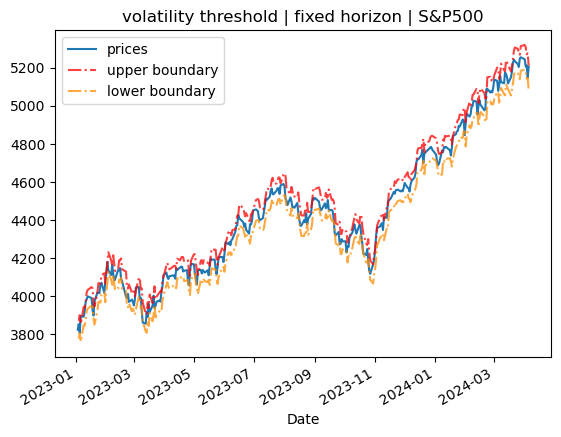

In [20]:
data['Close']['2023':].plot(grid = False, label = 'prices')
plt.plot(
    (data['Close']['2023':] + data['Close']['2023':] * ret.std()).shift(1), 
    color = 'red', 
    linestyle = '-.', 
    alpha = 0.75,
    label = 'upper boundary'
)
plt.plot(
    (data['Close']['2023':] - data['Close']['2023':] * ret.std()).shift(1), 
    color = 'darkorange', 
    linestyle = '-.', 
    alpha = 0.75,
    label = 'lower boundary'
)
plt.legend()
plt.title('volatility threshold | fixed horizon | S&P500')
plt.show()

논문들은 대개 항상 time bar를 사용하므로 $h$는 고정된 기간을 의미한다. 참고 문헌에서 다수의 머신러닝 연구를 소개하고 있는데 그중 딕슨(Dixon, 2016)은 이 labeling 기법을 이용한 최근 예제이다. 그 인지도에도 불구하고 많은 경우 이 방법을 피해야 할 이유는 다음과 같다.

1. Chapter 2에서 살펴본 것처럼 time bar는 좋은 통계적 성질을 갖지 못한다
2. 관측된 변동성과 상관없이 동일한 임계값 $\tau$가 적용된다. $\tau = 0.01$이라 가정하면, 어떤 때에는 $\sigma_{t_{i,0}} = 0.0001$, 또 어떤 때에는 $\sigma_{t_{i,0}} = 0.01$의 실현 변동성에 가지는데 동일하게 $y_i = 1$로 labeling할 것이다. 이 경우 수익률 $r_{t_{i,0}, t_{i,0}+h}$가 예측 가능하고 통계적으로 유의한 경우라 하더라도 대다수의 labeling이 0 값을 가지게 된다.

다시 말해 time bar의 고정된 임계값에 따라 관측값을 labeling하는 것은 매우 흔한 오류이다. 좀 더 좋은 대안은 다음과 같다

1. 수익률의 rolling window로 계산된 지수가중 이동평균 표준편차로 측정해 그 값이 변하는 임계값 $\sigma_{i,0}$에 대해 labeling하는 것이다
2. 거래량 바나 달러 바의 변동성이 훨씬 더 상수에 가까우므로 이들을 이용하는 것이다

그러나 이 두가지 개선 사항도 고정 기간 기법의 핵심 결함을 해결하지 못하는데 경로가 가격을 따르기 때문이다. 모든 투자 전략에서 portfolio manager가 스스로 정하거나 리스크 부서에 의해 강제되든, 또는 마진 콜 때문이든 stop-loss limits(손절 제한)가 있다. 거래에서 손절되었을 포지션으로부터 수익을 낼 수 있는 전략을 구축한다는 것은 현실성이 없다. 관측값을 labeling할 때 이를 고려한 문헌이 하나도 없다는 사실은 투자와 관련된 학술지 논문의 현 수준을 보여준다.

### Computing Dynamic Thresholds

앞에서 논의한 것처럼 실제로 베팅에 내재된 위험 함수로 이익 실현(profit taking)과 손절 한도(stopping loss)를 설정하고자 한다. 그렇지 않다면 현재의 변동성을 고려했을 때 종종 너무 높은 수익을 원하거나($\tau > \sigma_{t_{i,0}}$), 때로는 너무 낮은 수익($\tau < \sigma_{t_{i,0}}$)을 설정할 것이다. 아래의 코드는 지수 가중 이동 평균 편차를 `lookback`일만큼 적용해, 일 중 추정 지점에서의 일별 변동성을 계산한다. `pandas.Series.ewm`함수를 좀 더 자세히 알고 싶다면 pandas 문서를 참조하라

In [21]:
from FinancialMachineLearning.features.volatility import daily_volatility

volatility = daily_volatility(data['Close'], lookback = 60)

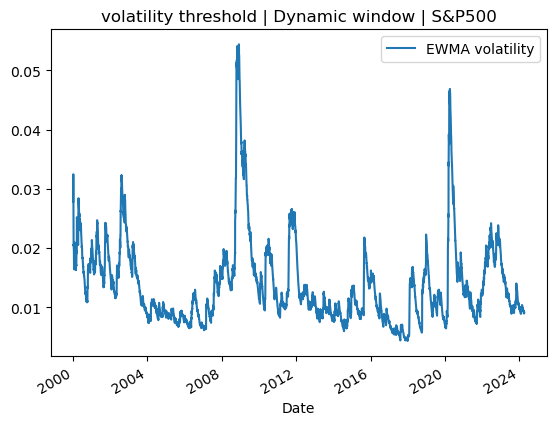

In [26]:
volatility.plot(grid = False, label = 'EWMA volatility')
plt.title('volatility threshold | Dynamic window | S&P500')
plt.legend()
plt.show()

이 함수의 출력을 이용해 Chapter 3의 나머지 부분에서 디폴트 이익 실현 및 손실 제한값을 설정할 수 있다

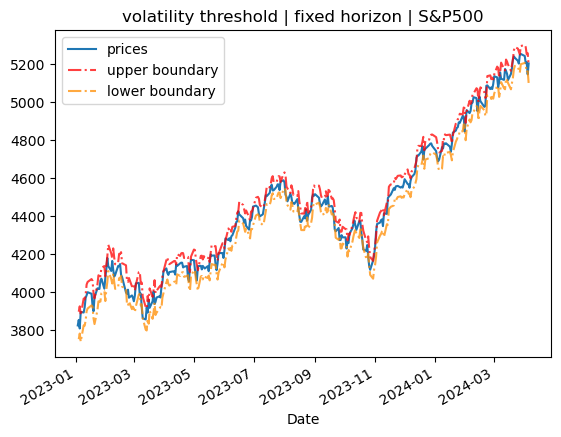

In [27]:
data['Close']['2023':].plot(grid = False, label = 'prices')
plt.plot(
    (data['Close']['2023':] + data['Close']['2023':] * volatility['2023':]).shift(1), 
    color = 'red', 
    linestyle = '-.', 
    alpha = 0.75,
    label = 'upper boundary'
)
plt.plot(
    (data['Close']['2023':] - data['Close']['2023':] * volatility['2023':]).shift(1), 
    color = 'darkorange', 
    linestyle = '-.', 
    alpha = 0.75,
    label = 'lower boundary'
)
plt.legend()
plt.title('volatility threshold | fixed horizon | S&P500')
plt.show()